## Введение в машинное обучение

## НИУ ВШЭ

В этой лабораторной работе вы реализуете решающее дерево и попрактикуетесь в решении задач классификации.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from typing import Iterable, List, Tuple, Union
from collections import Counter
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

# Решающее дерево своими руками (8 баллов + бонус)

В этой части для тестирования будем использовать датасет breast cancer. По предоставленной информации о ядрах клеток нужно предсказать присутствуют ли на изображении раковые клетки (класс 0) или нет (класс 1).

In [2]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(data=breast_cancer["data"], columns=breast_cancer["feature_names"])

# добавим искуственный категориальный признак
X['mean area cat'] = pd.qcut(X['mean area'], 5, labels=['smallest','small','medium','big', 'largest']).astype('object') 

X["target"] = breast_cancer["target"]
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,mean area cat,target
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,medium,1
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090,medium,0
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247,medium,1
446,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075,largest,0
210,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865,largest,0


### 1. Оцениванием качество разбиения (1 балл)

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

Используйте функции для подсчета значения критерия ошибки, а также для разбиения вершины из семинара:

In [3]:
def split_node(R_m: np.ndarray, feature: str, t: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split a fixed set of objects R_m with given feature name and threshold t
    """
    mask = R_m[feature] <= t
    R_l = R_m.loc[mask]
    R_r = R_m.loc[~mask]
    return R_l, R_r


def q_error(R_m: np.ndarray, feature: str, t: float) -> float:
    """
    Compute error criterion for the given objects R_m, feature name and threshold t
    """
    R_l, R_r = split_node(R_m, feature, t)
    return  len(R_l) / len(R_m) * H(R_l['target']) + len(R_r) / len(R_m) * H(R_r['target'])

__(0.5 балла)__ Реализуйте функцию для вычисления критерия информативности. На семинаре мы рассматривали решающее дерево для регрессии и в качестве критерия качества разбиения использовали дисперсию целевой переменной. Для классификации лучше использовать другие критерии, например энтропию:

$$H(R) = -p_0\log_{2}{p_0} -p_1\log_{2}{p_1},$$ где $p_1$, $p_0$ — доля объектов среди $R$, которые относятся к классу 1 и 0 соответственно.

In [4]:
X['target']

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64

In [14]:
def H(y: np.ndarray) -> float:
    """
    Compute entropy for vector y with classes of objects R
        
    """
    y = np.array(y)
    p1 = y.sum() / len(y)
    p0 = 1 - p1
    if (p1 != 0) and (p0 != 0):
        entropy = -1 * p0 * np.log2(p0) - p1 * np.log2(p1)
    else: 
        entropy = 0

    return entropy

# Проверяем на простых примерах
assert np.isclose(H([0,0,0,0,0,1]), 0.650022)
assert np.isclose(H([0,0,0,0,0,0]), 0)

__(0.5 балла)__ Выберите признак, который как вам кажется может быть полезен для предсказания и порог для него. Сравните значение критерия информативности для объектов выборки до разбиения и взвешенной суммы критериев информативности для объектов после разбиения ($Q(R_m,j,t)$). Какой можно сделать вывод?

In [19]:
R_l, R_r = split_node(X, 'mean radius', 12)

In [28]:
H(X['target'])

0.9526351224018599

In [31]:
H(R_l['target'])/2 + H(R_r['target'])/2

0.6092022850185591

Критерий информативности entropy можно интерпретировать как мера неопределённости случайной величины и так как критерий энтропии
достигает своего максимума при равномерном распределении и понижается чем более "вырожденным" расспределение 
является, можем сделать вывод что признак и порог разбиения были выбраны правильно и мы повысили "определенность" 

### 2. Ищем наилучшее разбиение (2 балла)

Теперь нужно найти наилучшее разбиение множества объектов $R_m$ в данной вершине, то есть такой порог $t$ для некоторого признака, где значение критерия ошибки $Q(R_m, j, t)$ минимально.

__(1 балл)__ Модифицируйте функцию *get_optimal_split* из семинара так, чтобы:
- Не было случаев, когда в одно из поддеревьев попадает 0 объектов 
- В качестве порога использовалось среднее двух различных соседних (при сортировке) значений признака 
- При одинаковых значениях критерия ошибки выбирался минимальный сплит 

__(Бонусные 0.5 балла)__ Перепешите функцию так, чтобы не использовались циклы.

In [183]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """
    R_m = R_m.copy()
    Q_array = []
    feature_values = np.unique(R_m[feature])
    
#     сортируем значения, убираем одинаковые значения признака и создаем список порогов
#     из средних значений соседних различных значений (задача 2)
    R_m.sort_values(by=feature, inplace=True)
    R_m.drop_duplicates(subset=[feature], inplace=True)
    t_lst = (np.array(R_m[feature][1:]) + np.array(R_m[feature][:-1])) / 2
#     так как теперь порогами являются не значения признака а средние близлежащих, то не будет случая когда в поддереве
#     находятся 0 объектов так как самый маленький порог больше минимального значения признака и максимальный порог меньше 
#     максимального значения признака (кроме случая когда не остается элементов в последовательности, его мы проработали ниже) 
#     (задача 1)
    
    Q_array = list(map(lambda t: q_error(R_m, feature, t), t_lst))
#     убрали циклы

#     Минимальный сплит озночает что разница в размерах поддатасетов должна быть максимальная после сплита
#     если так то до середины списка Q_array надо выбирать первый встречный из одинаковых значениях критерия а после середины -
#     выбирать последний встречный из одинаковых значениях критерия
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    if len(Q_array) == 0:
        return None
    
    minimum_id = np.argmin(Q_array[:len(Q_array//2)])
    minimum_id_2 = np.argmin(Q_array[len(Q_array//2)::-1])
    minimum = min(Q_array[minimum_id], Q_array[minimum_id_2])
    if minimum == Q_array[minimum_id_2]:
        minimum_id = minimum_id_2
    opt_threshold = feature_values[minimum_id]
    opt_q_error = Q_array[minimum_id]
    
    return opt_threshold, opt_q_error, Q_array, t_lst

__(0.25 балла)__ Постройте график зависимости критерия ошибки от выбранного порога для того же признака что и в 1ом задании и отметьте точку где достигается минимум.

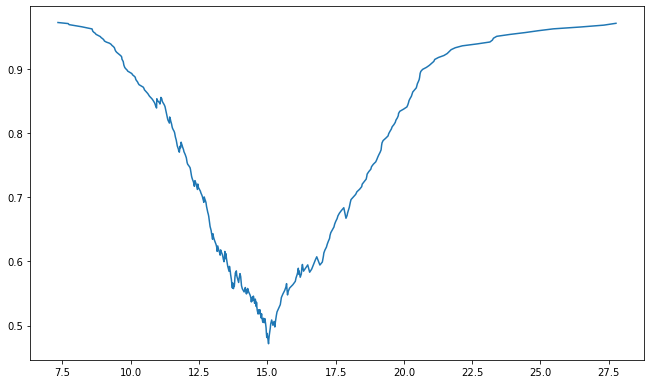

In [87]:
a, _, Q_array, t_lst = get_optimal_split(X, 'mean radius')
plt.plot(t_lst, Q_array)

In [88]:
print('минимум достигается припороге со значением', a)

минимум достигается припороге со значением 15.04


__(0.75 балла)__ Найдите признак с минимальным значением критерия ошибки. Постройте на одном графике распределения значений этого признака для нулевого и первого класса (можно использовть seaborn) и добавьте прямую указывающую местоположение порога. 

уберем признак с строковыми значениями 'mean area cat' так как модель не работает с строковыми значениями,
тем более что он создан исскуственно и в нем содержится та же информация что в 'mean area'

In [171]:
X_aux = X.drop(columns=['mean area cat'])
cols = X_aux.columns[:-1]
lst = []
for column in cols:
    a, b, Q_array, t_lst = get_optimal_split(X_aux, column)
    lst.append(b)
    

X_aux.columns[np.argmin(lst)]

'worst perimeter'

In [173]:
a, _, _, _ = get_optimal_split(X, 'worst perimeter')

In [142]:
a

115.0

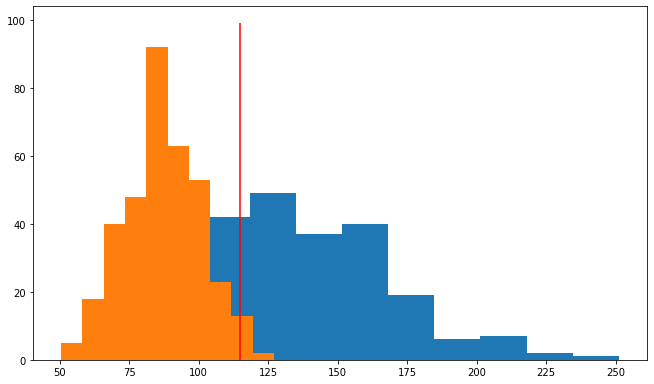

In [121]:
plt.hist(X['worst perimeter'].loc[X['target'] == 0])
plt.hist(X['worst perimeter'].loc[X['target'] == 1])

y = np.arange(100)
plt.vlines(a, y.min(), y.max(), colors='red')

### 3. Строим дерево (5 баллов)

Теперь можно реализовать алгоритм целиком. Начинаем строить дерево с корня. В корне дерева находится вся обучающая выборка. Затем используем жадный алгоритм:

0. Проверяем критерий остановки - все элементы в вершине относятся к одному классу, ни по одному признаку нельзя разбить выборку, достигнута максимальная глубина дерева и пр.

1. Cреди всех признаков выбираем признак с минимальным значением критерия ошибки.

2. Разбиваем выборку на две подвыборки по наилучшему порогу для этого признака и из этих подвыборок получаем две новые дочерние вершины. 

3. Для каждой из них рекурсивно потворяем аналогичные действия.

__(3 балла)__ Заполните пропущенные строчки в функции __fit_node_ и реализуйте функцию __predict_node_.

In [269]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None
    ) -> None:
        
        if np.any(list(map(lambda x: x not in ('int64', 'float64', 'object'), feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой ("terminal" или "nonterminal"). Листовые вершины хранят значение класса для предсказания, 
        # нелистовые - правого и левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {"depth":0}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(
        self, 
        sub: pd.DataFrame, # подмножество объектов для данной вершины
        node: dict        # словарь для хранения информации о вершине
    ) -> None:
        
        
        # критерий остановки - проверяем что не все классы объектов в данной вершине одинаковы
        if np.all(sub['target'] == sub['target'].iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub['target'].iloc[0]
            return
        
        # ищем лучший признак для разбиения
        feature_best, threshold_best, q_best = None, None, None
        aux_lst = []
        aux_lst_1 = []
        for feature in sub.columns[:-1]:
            feature_type = self.feature_types[feature]
            # ищем оптимальный порог для текущего признака
            threshold, q, q_array, _ = get_optimal_split(sub, feature)
            aux_lst.append(q)
            aux_lst_1.append((threshold, q_array))
            

        feature_best = sub.columns[:-1][np.argmin(aux_lst)]
        threshold_best, q_best = aux_lst_1[np.argmin(aux_lst)]
            
        # выбираем класс для листовой вершины
        if feature_best is None or node["depth"] == self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
        
        # записываем полученное разбиение в атрибуты класса
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best
        sub_l, sub_r = split_node(sub, feature_best, threshold_best)
    
        # запускаем рекурсию
        node["left_child"], node["right_child"] = {"depth": node["depth"]+1}, {"depth": node["depth"]+1}
        self._fit_node(sub_l, node["left_child"])
        self._fit_node(sub_r, node["right_child"])

    def _predict_node(self, x: pd.Series, node: dict):
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: pd.Series, элемент выборки
        :param node: dict, вершина дерева
        """
        
        if node['type'] == 'nonterminal':
            if x[node['feature_split']] > node["threshold"]:
                return self._predict_node(x, node["right_child"])
            else:
                return self._predict_node(x, node["left_child"])
        elif node['type'] == 'terminal':
            class_i = node['class'].copy()
            return class_i

    def fit(self, X: pd.DataFrame, y: np.ndarray) -> None:
        
        if 'object' in np.array(X.dtypes):
            X = pd.get_dummies(X)
            
        X['target'] = y
        self._fit_node(X, self._tree)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        predicted = []
        for ind, x in X.iterrows():
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

__(1 балл)__ Обучите решающее дерево на обучающей части датасета (исключив колонку "mean area cat") и сравните accuracy полученную на обучающей и тестовой части. Совпадают ли топовые признаки с минимальным значением ошибки из предпредыдущего задания с признаками по которым произошли разбиения в дереве?

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['target', "mean area cat"]), X['target'],\
                                                    test_size=.2, random_state=19)

In [270]:
tree = DecisionTree(feature_types=['int64'])

In [271]:
tree.fit(X_train, y_train)

In [272]:
tree.predict(X_test)

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1])

In [273]:
accuracy_score(y_test, tree.predict(X_test))

0.9736842105263158

__(1 балл)__ Как будет происходить разбиение в вершине дерева по категориальному признаку? Является ли оно эффективным? Исправьте одну из функций выше так, чтобы дерево не выдавало ошибку при обучении на датасете с категориальными признаками. 

По категориальному признаку разбиение должно происходить не по порогу а по принадлежности к классу, подругому будет некоректно. 
Исправим фуекцию так чтоб при нахождении типа не численного разбиение проходило по принадлежности

# Практическая часть (6 баллов)

__(2 балла)__ В этом задании нужно для того же датасета обучить несколько алгоритмов с помощью кросс-валидации и сравнить их качество по ROC AUC, accuracy и f1-score. Не забудьте удалить дополнительные колонки, которые были добавлены ранее.

1. Обучите и нарисуйте решающее дерево c глубиной 3. Настройте font_size или общий размер графика чтобы названия признаков были читабельны. Сравните его с деревом, которое вы написали самостоятельно. Для решающего дерева подберите оптимальный max_depth и min_samples_split по выбранной метрике.

2. Обучите логистическую регрессию c L2 регуляризацией и подберите для нее наилучший параметр.

3. Обучите SVM и выберите наиболее подходящее ядро и параметр регуляриации.


Выберите метрику, по которой вы будете выбирать наилучшие параметры. Почему для этого датасета стоит сравнивать предсказания не только по значению accuracy? Что важнее для этой задачи - оптимизировать precision или recall? 

In [286]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

[Text(0.5, 0.75, 'X[30] <= 0.5\ngini = 0.465\nsamples = 455\nvalue = [167, 288]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 167\nvalue = [167, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 288\nvalue = [0, 288]')]

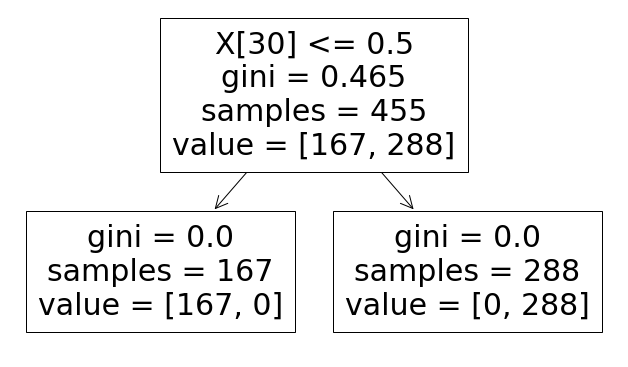

In [279]:
tree.plot_tree(tree1)

Заметим что критерий информативности стандартный установлен "gini" вместо энтропии как в нашем случае.
Будем оптимизировать метрику f1-score

In [289]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

tree1 = DecisionTreeClassifier()
parameters = {'max_depth':[3, 7, 12], 'min_samples_split':[5, 10, 15]}
clf = GridSearchCV(tree1, parameters, )
clf.fit(X_train, y_train, )

clf.best_params_

{'max_depth': 7, 'min_samples_split': 5}

In [293]:
tree1 = DecisionTreeClassifier(max_depth=7, min_samples_split=5).fit(X_train, y_train)
f1_score(y_test, tree1.predict(X_test))

0.9571428571428571

In [294]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression('l2')

In [295]:
tree1 = DecisionTreeClassifier()
parameters = {'max_iter':[30, 80, 120], 'C':[0.5, 0.8, 1]}
clf = GridSearchCV(log_reg, parameters, )
clf.fit(X_train, y_train, )

clf.best_params_

{'C': 0.8, 'max_iter': 120}

In [304]:
reg2 = LogisticRegression('l2', C=0.8, max_iter=120).fit(X_test, y_test)
f1_score(y_test, reg2.predict(X_test))

0.9705882352941176

In [305]:
from sklearn.svm import SVC

In [306]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [308]:
svc = SVC(kernel='linear', C=1).fit(X_test, y_test)
f1_score(y_test, svc.predict(X_test))

0.9855072463768116

В данной задаче цена ошибки типа False Positive имеет очень большую цену, так как на кону человеческое здоровие по этому лучше будет оптимизировать Recall. Чтоб быть уверенными что отловили максимальное количество элементов положительного класса (присутствие рака) из существующих, при этом не так важно если будем идентифицировать болезнь там где ее на самом деле нет

Теперь загрузим еще один [датасет](https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification). По данным о клиентам банка нужно предсказать будет ли клиент брать кредит на длительный срок или нет. И если да, то сотрудники банка позвонят и предложат ему кредит. 

In [418]:
df = pd.read_csv('new_train.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


__(0.5 балла)__ Изучите и подготовьте данные - проверьте типы колонок, соотношение классов, наличие пропусков (пропуски для категориальных переменных указаны как 'unknown'), повторяющихся объектов, проверьте частоты значений признаков и их смысл - возможно какие-то признаки можно удалить. 

In [419]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


удалим строки со значениями unknow

In [396]:
for i in df.columns:   
    df = df.loc[df[i] != 'unknown']
df.shape

(24305, 16)

(array([21237.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3068.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

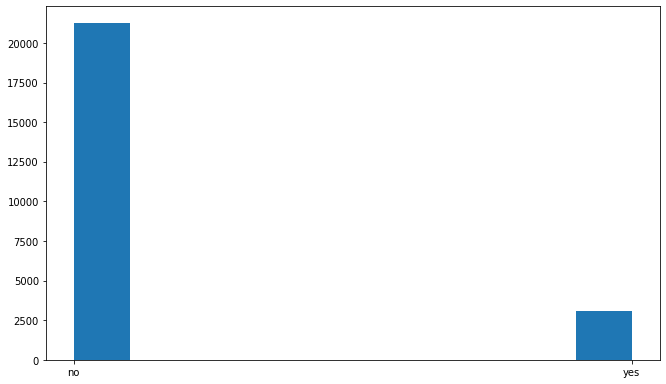

In [397]:
plt.hist(df['y'])

In [420]:
#уберем пропуски и дубликаты
df = df.dropna()
df = df.drop_duplicates()

In [421]:
df.pdays.value_counts()

999    31716
3        355
6        337
4         97
2         52
7         47
9         45
10        43
12        40
5         40
13        28
1         22
11        21
15        21
14        18
8         14
0         12
16         9
17         8
18         6
22         3
19         2
21         2
27         1
25         1
20         1
26         1
Name: pdays, dtype: int64

удалим признак pdays так как там явное преобладание значения 999, удалим признак так как он не несет много информации

In [422]:
df = df.drop(columns='pdays')

__(0.5 балла)__ Постройте графики с распределениями по каждому из категориальных признаков. Статистики должны быть выведены для обоих классов и либо расположены на одном графике, либо находиться на соседних графиках, чтобы можно было сравнить их между собой. Вам поможет plt.subplot(s) если вы используете matplotlib или продвинутые функции из seaborn, позволяющие автоматически строить сразу несколько графиков. Убедитесь что на графиках подписаны оси, все надписи читабельны и пр. Проанализируйте полученные результаты.

In [401]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'y'],
      dtype='object')

(array([ 854.,  973., 6958.,  492., 4534., 2294., 4344.,  842., 1869.,
        1139.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

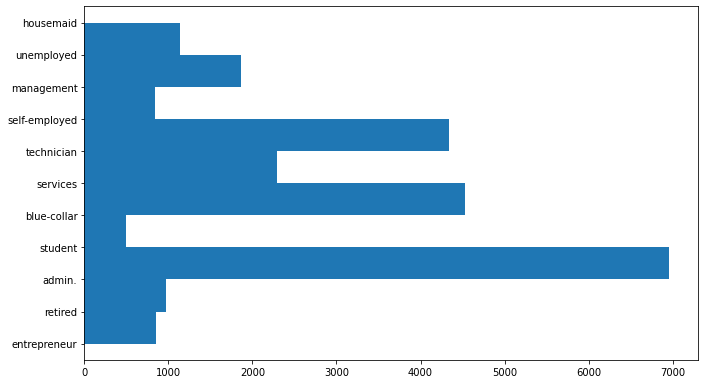

In [402]:
plt.hist(df['job'], bins=n_bins, orientation='horizontal')

(array([13948.,     0.,     0.,     0.,     0.,  2806.,     0.,     0.,
            0.,  7545.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

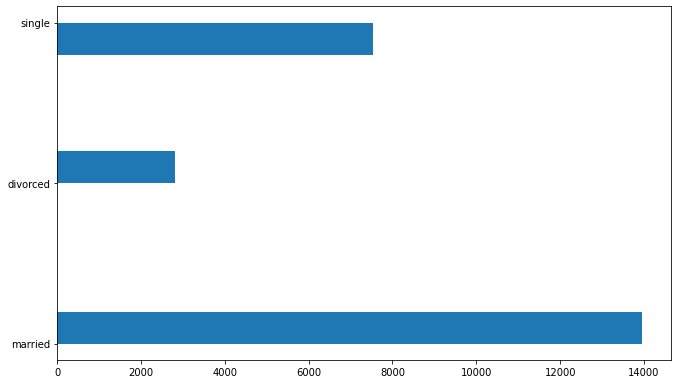

In [403]:
plt.hist(df['marital'], bins=n_bins, orientation='horizontal')

(array([8316., 1888.,    0., 3380.,    0., 6126., 3449.,    0., 1129.,
          11.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

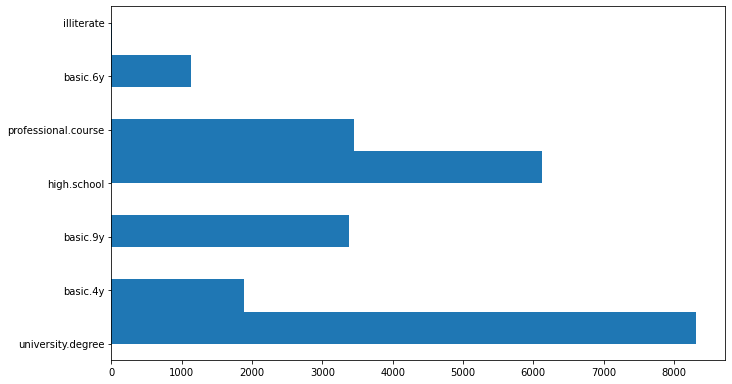

In [404]:
plt.hist(df['education'], bins=n_bins, orientation='horizontal')

(array([2.4296e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

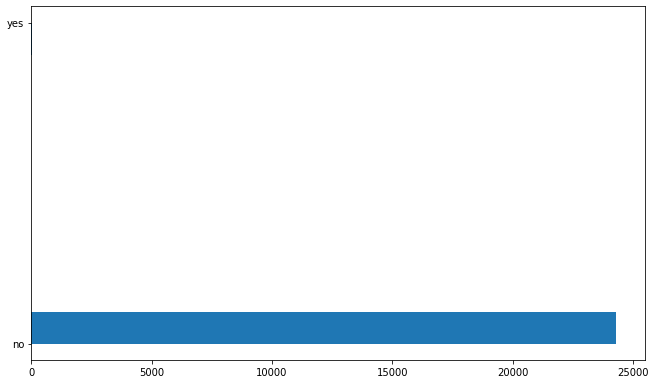

In [405]:
plt.hist(df['default'], bins=n_bins, orientation='horizontal')

(array([13948.,     0.,     0.,     0.,     0.,  2806.,     0.,     0.,
            0.,  7545.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

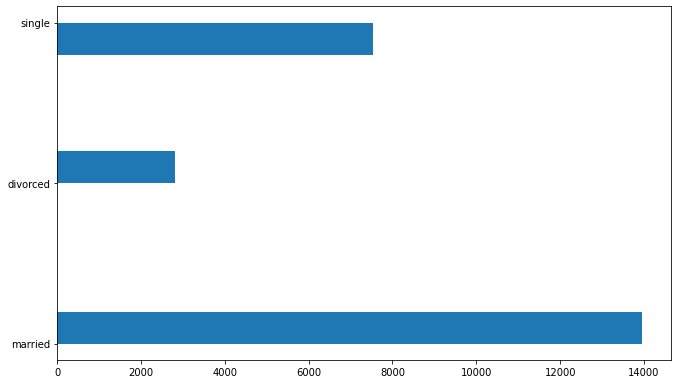

In [406]:
plt.hist(df['marital'], bins=n_bins, orientation='horizontal')

(array([ 7986.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 16313.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

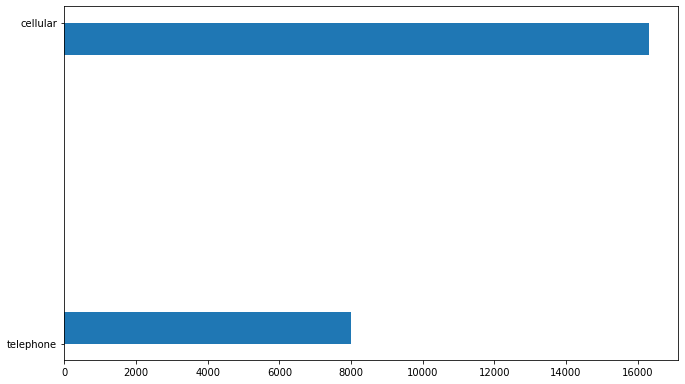

In [407]:
plt.hist(df['contact'], bins=n_bins, orientation='horizontal')

(array([2781., 4057., 7766., 2847., 3740.,  384.,  526., 1675.,  402.,
         121.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

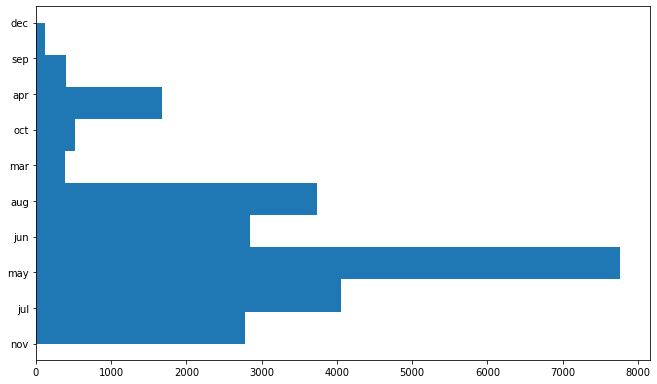

In [408]:
plt.hist(df['month'], bins=n_bins, orientation='horizontal')

(array([ 2801.,     0.,     0.,     0.,     0., 20539.,     0.,     0.,
            0.,   959.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

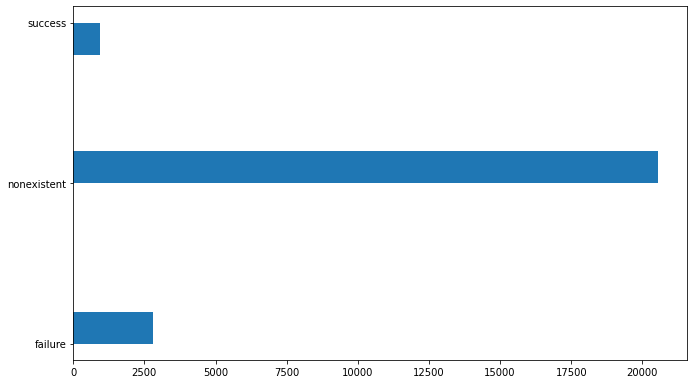

In [409]:
plt.hist(df['poutcome'], bins=n_bins, orientation='horizontal')

(array([11128.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13171.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

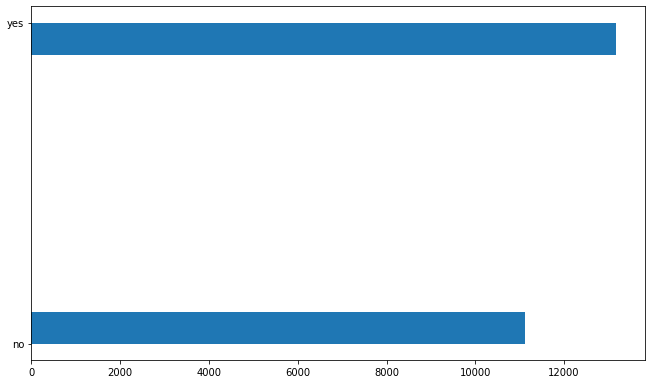

In [410]:
plt.hist(df['housing'], bins=n_bins, orientation='horizontal')

(array([20485.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3814.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

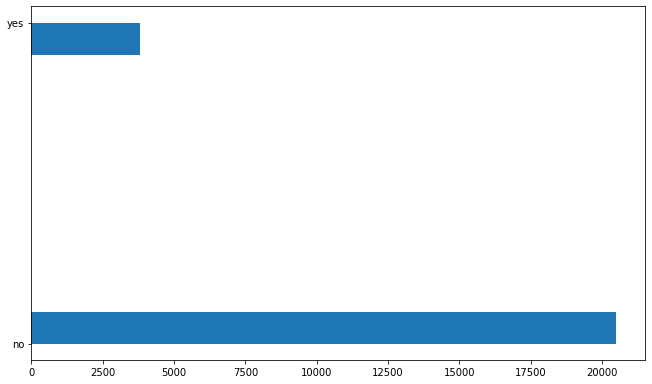

In [411]:
plt.hist(df['loan'], bins=n_bins, orientation='horizontal')

(array([21231.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3068.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

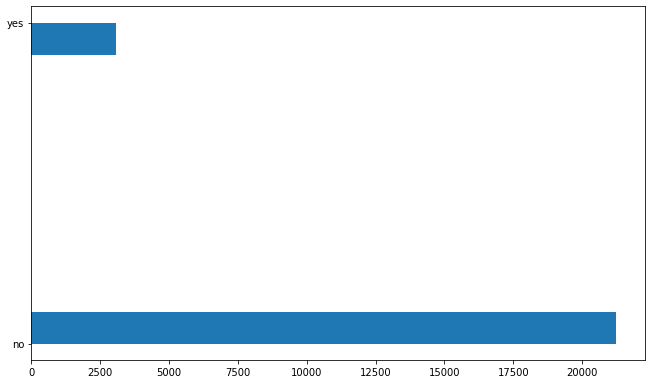

In [412]:
plt.hist(df['y'], bins=n_bins, orientation='horizontal')

__(0.5 балла)__ Проведите анализ числовых признаков - постройте попарные графики для признаков и график с корреляцией Пирсона.

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='duration', ylabel='age'>,
        <AxesSubplot:xlabel='campaign', ylabel='age'>,
        <AxesSubplot:xlabel='previous', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='duration'>,
        <AxesSubplot:xlabel='duration', ylabel='duration'>,
        <AxesSubplot:xlabel='campaign', ylabel='duration'>,
        <AxesSubplot:xlabel='previous', ylabel='duration'>],
       [<AxesSubplot:xlabel='age', ylabel='campaign'>,
        <AxesSubplot:xlabel='duration', ylabel='campaign'>,
        <AxesSubplot:xlabel='campaign', ylabel='campaign'>,
        <AxesSubplot:xlabel='previous', ylabel='campaign'>],
       [<AxesSubplot:xlabel='age', ylabel='previous'>,
        <AxesSubplot:xlabel='duration', ylabel='previous'>,
        <AxesSubplot:xlabel='campaign', ylabel='previous'>,
        <AxesSubplot:xlabel='previous', ylabel='previous'>]], dtype=object)

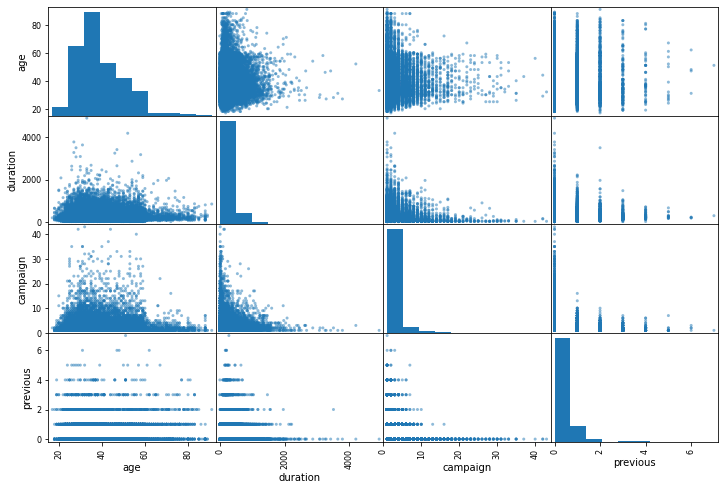

In [413]:
from pandas.plotting import scatter_matrix
attributes=['age', 'day_of_week', 'duration', 'campaign', 'previous']
scatter_matrix(df[attributes],figsize=(12,8))


Не один из признаков не кореллируит явно линейно между собой а значит можем использовать их все для достижения лучшего результата

__(0.5 балл)__ Преобразуйте категориальные признаки. Подумайте какие признаки лучше закодировать с помощью one-hot encoding, а какие с помощью label-encoding.

если классы сравнимы и имеют определенну разницу между собой (например: до 18 лет, 18-30, 30-45, 45-60, 60+) тогда можно 
преобразовать их в один столбец к числам (например 1, 2, 3, 4, 5). если же классы отличаются качественно (собака, кот, лошадь) 
а не количественно
тогда надо использовать onehotencoding

In [423]:
df = pd.get_dummies(df)

__(1 балл)__ В этом датасете отношение между положительными примерами и отрицательными практически 1:8. Поэтому хорошей идеей будет сбалансировать датасет (oversampling - добавить элементы менее популярного класса на основе имеющихся или undersampling - наоборот убрать элементы более популярного класса. см. [imblearn](https://imbalanced-learn.org/stable/over_sampling.html#a-practical-guide)) или пропорционально изменить веса классов в самих моделях (параметр class_weight), а также использовать чувствительные к таким случаям метрики. 

Разбейте датасет на train и test, используйте параметр stratify, чтобы соотношение классов не изменилось после разбиения датасета на две части. Аналогично в дальнейшем при использовании кросс-валидации используйте версию функции сохраняющую соотношение классов (StratifiedKFold). 

Подберите параметры логистической регрессии и решающего дерева с помощью кросс-валидации по AUC PR (площадь под Precision-Recall кривой). Для тестовой части датасета выведите получившиеся значения AUC PR, f1-score, PR-кривую и выведите матрицы для истинных значений и предсказаний (confusion matrix). Их можно красиво вывести с помощью seaborn.heatmap(). На что стоит больше обращать внимание - на ошибку первого или второго рода?

(array([29696.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 29230.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

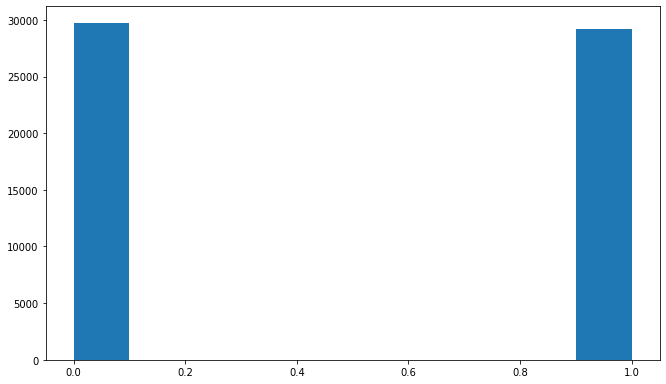

In [424]:
# Преобладание класса "no" сбалансируем данные, сбалансируем классы методом oversampling


for i in range(3):
    df = df.append(df.loc[df['y_no'] == 0])

plt.hist(df['y_no'])

In [427]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['y_no', 'y_yes']), df['y_yes'], stratify=df['y_yes'])

In [428]:
from sklearn.model_selection import cross_validate

In [429]:
tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15).fit(X_train, y_train)
cv_results = cross_validate(tree, X_train, y_train, cv=3)
print(sorted(cv_results.keys()))

cv_results['test_score']

['fit_time', 'score_time', 'test_score']


array([0.94834374, 0.94650737, 0.94684679])

In [432]:
log_cl = LogisticRegression('l2', C=0.9).fit(X_train, y_train)
cv_results = cross_validate(log_cl, X_train, y_train, cv=3)
print(sorted(cv_results.keys()))

cv_results['test_score']

['fit_time', 'score_time', 'test_score']


array([0.83803964, 0.84060824, 0.84006517])

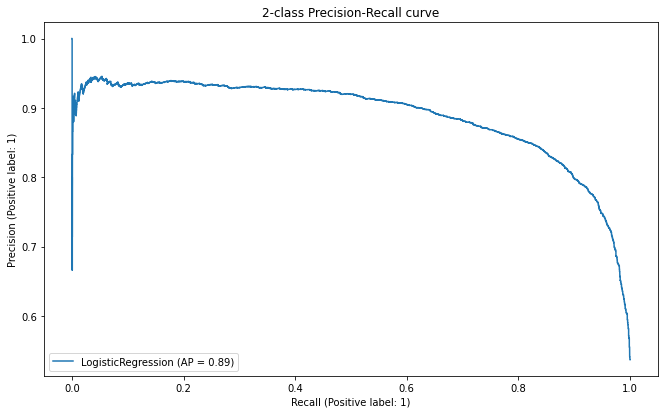

In [433]:
from sklearn.metrics import auc, f1_score
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    log_cl, X_test, y_test)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [434]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, log_cl.predict(X_test))

array([[6214, 1094],
       [1302, 6122]])

Стоит больше обращать внимание на ошибки False Negative так как лучше недодать кредитов тем кто вернет чем отдать слишком много кредитов и процент неуплат повысится, значит надо оптимизировать precision 

__(0.5 балла)__ Рассмотрим задачу с точки зрения прибыли для банка. Маркетинговая компания требует значительных финансовых затрат, и ее эффективность напрямую зависит от качества нашей модели. Поэтому в качестве дополнительной метрики качества разумно использовать общую прибыль банка в той или иной форме. Мы будем рассматривать очень простую модель. Пусть каждый клиент после возврата всех процентов по кредиту (и с учетом всех расходов на обслуживание) приносит банку в среднем 10000 у.е., затраты на привлечение одного клиента составляют 100 у.е. Тогда сколько составит прибыль банка (доходы - расходы) если работники банка свяжутся со всеми клиентами, которых предсказала наша лучшая модель как подходящих на тестовой части и они все согласятся открыть кредит? Сколько составят расходы на маркетинг? В данной модели мы не учитываем что кредит может быть не возвращен в срок.

In [439]:
#если все предсказанные согласились бы взять кредит
6214 * (10000 - 100) + 1094 * (10000 - 100)

72349200

In [438]:
# разход
(6214 + 1094) * 100

730800